# *scANVI: Deep Generative Modeling for Single Cell Data with Pyro*

In this tutorial we show how to use Pyro to construct a semi-supervised deep generative model of transcriptomics data that can be used to propagate labels
from a small set of labeled cells to a larger set of unlabeled cells. 
In particular we use a dataset of peripheral blood mononuclear cells (PBMC) from 10x Genomics and
(approximately) reproduce Figure 6 in  [Probabilistic Harmonization and Annotation of Single-cell Transcriptomics Data with Deep Generative Models](https://www.embopress.org/doi/full/10.15252/msb.20209620).

(Note that the code below is also available as a [script](https://github.com/pyro-ppl/pyro/blob/dev/examples/scanvi/scanvi.py).)

In [1]:
import os

smoke_test = ('CI' in os.environ)  # for continuous integration tests

if not smoke_test:
    # install scanpy (used for pre-processing and UMAP)
    !pip install -q scanpy==1.8.2
    #!pip install -q umap-learn==0.5.2
    # install scvi (used to get data)
    !pip install -q scvi-tools[tutorials]

In [2]:
# various import statements
import numpy as np

import torch
import torch.nn as nn
from torch.nn.functional import softplus, softmax
from torch.distributions import constraints
from torch.optim import Adam

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions.util import broadcast_shape
from pyro.optim import MultiStepLR
from pyro.infer import SVI, config_enumerate, TraceEnum_ELBO
from pyro.contrib.examples.scanvi_data import get_data

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Data pre-processing

In [3]:
# Download and pre-process data
batch_size = 100
if not smoke_test:
    dataloader, num_genes, l_mean, l_scale, anndata = get_data(dataset='pbmc', cuda=True, batch_size=batch_size)
else:
    dataloader, num_genes, l_mean, l_scale, anndata = get_data(dataset='mock')

Global seed set to 0
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


INFO     File data/PurifiedPBMCDataset.h5ad already downloaded                               
INFO     Using batches from adata.obs["batch"]                                               
INFO     Using labels from adata.obs["labels"]                                               
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 42919 cells, 21932 vars, 4        
         batches, 4 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


The PBMC transcriptomics data are encoded as a count matrix of size N x G, with N=20,000 cells and G=21,932 genes.



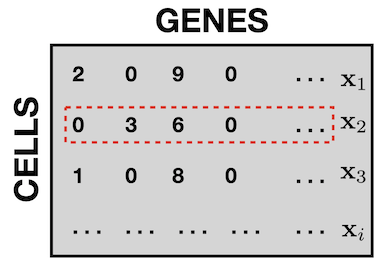

In [4]:
print("Count data matrix shape:", dataloader.data_x.shape)
print("Mean counts per cell: {:.1f}".format(dataloader.data_x.sum(-1).mean().item()))

Count data matrix shape: torch.Size([20000, 21932])
Mean counts per cell: 1418.6


In addition 200 of the 20,000 cells have been labeled using a hand-curated list of marker genes that includes e.g. CD4 and CD8B. This annotation introduces four discrete cell types:
- CD8 Naive T cell
- CD4 Naive T cell
- CD4 Memory T cell
- CD4 Regulatory T cell

In [5]:
print("Number of labeled cells:", dataloader.num_labeled)

Number of labeled cells: 200


Our high-level goal is to learn a parametric model p(**x**) that provides a good fit to the observed count data {**x**_i}. To build a sufficiently rich and flexible model we introduce several latent variables that can capture variability in the data. In particular we introduce the following latent variables:
- two continuous latent variables **z**_1 and **z**_2 which are intended to encode things like cell state
- a scalar latent variable **ℓ** that encodes the total number of counts in a cell, and thus reflects cell size, capture efficiency, etc
- a discrete latent variable **y** that encodes the four possible cell labels

The structure of our model can be represented as a plate diagram, with the index *i* ranging over the N cells (in other words we are modeling the count matrix row-by-row). In particular each cell has its own copy of each of these latent variables:


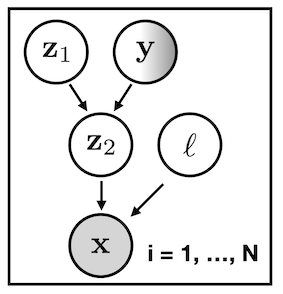

Note that in this diagram the partial shading of **y** indicates that sometimes **y** is unobserved and sometimes it is not: this is a semi-supervised model.

Before we write down a *complete* specification of this model in Pyro (including in particular neural networks), let's start by writing some code that illustrates the high-level structure of the model:

In [6]:
def model_sketch(x, y=None):
    # This gene-level parameter modulates the variance of the 
    # observation distribution for our vector of counts x
    theta = pyro.param("inverse_dispersion", 10.0 * torch.ones(num_genes),
                       constraint=constraints.positive)

    # The plate statement encodes that each datapoint (i.e. cell count vector x_i)
    # is conditionally independent given its own latent variables.
    with pyro.plate("batch", len(x)):
        # Define a unit Normal prior distribution for z1
        z1 = pyro.sample("z1", dist.Normal(0, torch.ones(latent_dim)).to_event(1))
        # Define a uniform categorical prior for y.
        # Note that if y is None (i.e. y is unobserved) then y will be sampled;
        # otherwise y will be treated as observed.        
        y = pyro.sample("y", dist.OneHotCategorical(logits=torch.zeros(num_labels)),
                        obs=y)

        # Pass z1 and y to the z2 decoder neural network
        z2_loc, z2_scale = z2_decoder(z1, y)  
        # Define the prior distribution for z2. The parameters of this distribution
        # depend on both z1 and y.        
        z2 = pyro.sample("z2", dist.Normal(z2_loc, z2_scale).to_event(1))

        # Define a LogNormal prior distribution for the log count variable ℓ
        l = pyro.sample("l", dist.LogNormal(l_loc, l_scale).to_event(1))

        # We now construct the observation distribution. To do this we 
        # first pass z2 to the x decoder neural network. 
        gate_logits, mu = x_decoder(z2)
        # Using the outputs of the neural network we can define the parameters
        # of our ZINB observation distribution.
        # Note that by construction mu is normalized (i.e. mu.sum(-1) == 1) and the
        # total scale of counts for each cell is determined by the latent variable ℓ.
        # That is, `l * mu` is a G-dimensional vector of mean gene counts.
        nb_logits = (l * mu).log() - theta.log()
        x_dist = dist.ZeroInflatedNegativeBinomial(gate_logits=gate_logits, 
                                                   total_count=theta,
                                                   logits=nb_logits)
        # Observe the datapoint x using the observation distribution x_dist
        pyro.sample("x", x_dist.to_event(1), obs=x)

Recall that in Variational Inference it's necessary to specify a variational distribution. In Pyro we call these *guides*. While Pyro includes some machinery for constructing these automatically, for complex models it's usually necessary to build these by hand in order to get the best possible performance. Let's sketch the high-level structure of the guide we use for this model:

In [7]:
# The guide specifies the variational distribution
def guide_sketch(self, x, y=None):
    # This plate statement matches the plate in the model
    with pyro.plate("batch", len(x)):
        # We pass the observed count vector x to an encoder network
        # that generates the parameters we use to define the variational
        # distributions for the latent variables z2 and ℓ.
        z2_loc, z2_scale, l_loc, l_scale = z2l_encoder(x)
        pyro.sample("l", dist.LogNormal(l_loc, l_scale).to_event(1))
        z2 = pyro.sample("z2", dist.Normal(z2_loc, z2_scale).to_event(1))

        # We only need to specify a variational distribution over y if y is unobserved
        if y is None:
            # We use the `classifier` neural network to turn the latent code
            # z2 into logits that we can use to specify a distribution over y.
            y_logits = classifier(z2)
            y_dist = dist.OneHotCategorical(logits=y_logits)
            y = pyro.sample("y", y_dist)

        # Finally we generate the parameters for the z1 distribution by
        # passing z2 and y through an encoder neural network z1_encoder.
        z1_loc, z1_scale = z1_encoder(z2, y)
        pyro.sample("z1", dist.Normal(z1_loc, z1_scale).to_event(1))

### Define some helper functions for making fully-connected neural networks and reshaping tensors

In [8]:
# Helper for making fully-connected neural networks
def make_fc(dims):
    layers = []
    for in_dim, out_dim in zip(dims, dims[1:]):
        layers.append(nn.Linear(in_dim, out_dim))
        layers.append(nn.BatchNorm1d(out_dim))
        layers.append(nn.ReLU())
    return nn.Sequential(*layers[:-1])  # Exclude final ReLU non-linearity

# Splits a tensor in half along the final dimension
def split_in_half(t):
    return t.reshape(t.shape[:-1] + (2, -1)).unbind(-2)

# Helper for broadcasting inputs to neural net
def broadcast_inputs(input_args):
    shape = broadcast_shape(*[s.shape[:-1] for s in input_args]) + (-1,)
    input_args = [s.expand(shape) for s in input_args]
    return input_args

The main thing we need to do to complete the specification of our model and guide is define the various decoder/encoder neural networks. Since this is largely just a matter of invoking standard PyTorch API, we do not go into great detail here. We limit ourselves to taking a quick look at `XDecoder`, which is the decoder neural network we use to specify the observation distribution p(**x** | **z**_2) used in the model:

In [9]:
# Used in parameterizing p(x | z2)
class XDecoder(nn.Module):
    # This __init__ statement is executed once upon construction of the neural network.
    # Here we specify that the neural network has input dimension z2_dim
    # and output dimension 2 * num_genes.
    def __init__(self, num_genes, z2_dim, hidden_dims):
        super().__init__()
        dims = [z2_dim] + hidden_dims + [2 * num_genes]
        self.fc = make_fc(dims)

    # This method defines the actual computation of the neural network. It takes
    # z2 as input and spits out two parameters that are then used in the model
    # to define the ZINB observation distribution. In particular it generates
    # `gate_logits`, which controls zero-inflation, and `mu` which encodes the
    # relative frequencies of different genes.
    def forward(self, z2):
        gate_logits, mu = split_in_half(self.fc(z2))
        # Note that mu is normalized so that total count information is
        # encoded by the latent variable ℓ.
        mu = softmax(mu, dim=-1)
        return gate_logits, mu

We now define the remaining encoder and decoder neural networks:

In [10]:
# Used in parameterizing p(z2 | z1, y)
class Z2Decoder(nn.Module):
    def __init__(self, z1_dim, y_dim, z2_dim, hidden_dims):
        super().__init__()
        dims = [z1_dim + y_dim] + hidden_dims + [2 * z2_dim]
        self.fc = make_fc(dims)

    def forward(self, z1, y):
        z1_y = torch.cat([z1, y], dim=-1)
        # We reshape the input to be two-dimensional so that nn.BatchNorm1d behaves correctly
        _z1_y = z1_y.reshape(-1, z1_y.size(-1))
        hidden = self.fc(_z1_y)
        # If the input was three-dimensional we now restore the original shape
        hidden = hidden.reshape(z1_y.shape[:-1] + hidden.shape[-1:])
        loc, scale = split_in_half(hidden)
        # Here and elsewhere softplus ensures that scale is positive. Note that we generally
        # expect softplus to be more numerically stable than exp.
        scale = softplus(scale)
        return loc, scale

# Used in parameterizing q(z2 | x) and q(l | x)
class Z2LEncoder(nn.Module):
    def __init__(self, num_genes, z2_dim, hidden_dims):
        super().__init__()
        dims = [num_genes] + hidden_dims + [2 * z2_dim + 2]
        self.fc = make_fc(dims)

    def forward(self, x):
        # Transform the counts x to log space for increased numerical stability.
        # Note that we only use this transformation here; in particular the observation
        # distribution in the model is a proper count distribution.
        x = torch.log(1 + x)      
        h1, h2 = split_in_half(self.fc(x))
        z2_loc, z2_scale = h1[..., :-1], softplus(h2[..., :-1])
        l_loc, l_scale = h1[..., -1:], softplus(h2[..., -1:])
        return z2_loc, z2_scale, l_loc, l_scale

# Used in parameterizing q(z1 | z2, y)
class Z1Encoder(nn.Module):
    def __init__(self, num_labels, z1_dim, z2_dim, hidden_dims):
        super().__init__()
        dims = [num_labels + z2_dim] + hidden_dims + [2 * z1_dim]
        self.fc = make_fc(dims)

    def forward(self, z2, y):
        # This broadcasting is necessary since Pyro expands y during enumeration (but not z2)
        z2_y = broadcast_inputs([z2, y])
        z2_y = torch.cat(z2_y, dim=-1)
        # We reshape the input to be two-dimensional so that nn.BatchNorm1d behaves correctly
        _z2_y = z2_y.reshape(-1, z2_y.size(-1))
        hidden = self.fc(_z2_y)
        # If the input was three-dimensional we now restore the original shape
        hidden = hidden.reshape(z2_y.shape[:-1] + hidden.shape[-1:])
        loc, scale = split_in_half(hidden)
        scale = softplus(scale)
        return loc, scale

# Used in parameterizing q(y | z2)
class Classifier(nn.Module):
    def __init__(self, z2_dim, hidden_dims, num_labels):
        super().__init__()
        dims = [z2_dim] + hidden_dims + [num_labels]
        self.fc = make_fc(dims)

    def forward(self, x):
        logits = self.fc(x)
        return logits

At this juncture we can put everything together. We will package our Pyro model and guide as a PyTorch `nn.Module`. We briefly discuss some of the more technical points that were swept under the rug in our high-level specifications `model_sketch` and `guide_sketch` introduced above:
- We use `pyro.module` statements to register the various neural networks with Pyro (this ensures their parameters get trained).
- The [semi-supervised modeling framework](https://arxiv.org/abs/1406.5298) upon which scANVI is based includes an additional term in the ELBO loss function that ensures that the `classifier` neural network learns from both labeled and unlabeled data. This explains the presence of the `pyro.factor` statement in the guide, which essentially just adds an auxiliary cross entropy loss term.
- In defining `nb_logits` below we use a fudge factor `epsilon` to ensure numerical stability. Fitting flexible models equipped with neural networks to high-dimensional data inevitably requires paying some attention to numerical issues.

In [11]:
# Packages the scANVI model and guide as a PyTorch nn.Module
class SCANVI(nn.Module):
    def __init__(self, num_genes, num_labels, l_loc, l_scale, 
                 latent_dim=10, alpha=0.01, scale_factor=1.0):
        self.num_genes = num_genes
        self.num_labels = num_labels

        # This is the dimension of both z1 and z2
        self.latent_dim = latent_dim

        # The next two hyperparameters determine the prior over the log_count latent variable `l`
        self.l_loc = l_loc
        self.l_scale = l_scale

        # This hyperparameter controls the strength of the auxiliary classification loss
        self.alpha = alpha
        self.scale_factor = scale_factor

        super().__init__()

        # Setup the various neural networks used in the model and guide
        self.z2_decoder = Z2Decoder(z1_dim=self.latent_dim, y_dim=self.num_labels,
                                    z2_dim=self.latent_dim, hidden_dims=[50])
        self.x_decoder = XDecoder(num_genes=num_genes, hidden_dims=[100], z2_dim=self.latent_dim)
        self.z2l_encoder = Z2LEncoder(num_genes=num_genes, z2_dim=self.latent_dim, hidden_dims=[100])
        self.classifier = Classifier(z2_dim=self.latent_dim, hidden_dims=[50], num_labels=num_labels)
        self.z1_encoder = Z1Encoder(num_labels=num_labels, z1_dim=self.latent_dim,
                                    z2_dim=self.latent_dim, hidden_dims=[50])

        self.epsilon = 0.006

    def model(self, x, y=None):
        # Register various nn.Modules (i.e. the decoder/encoder networks) with Pyro
        pyro.module("scanvi", self)

        # This gene-level parameter modulates the variance of the observation distribution
        theta = pyro.param("inverse_dispersion", 10.0 * x.new_ones(self.num_genes),
                           constraint=constraints.positive)

        # We scale all sample statements by scale_factor so that the ELBO loss function
        # is normalized wrt the number of datapoints and genes. 
        # This helps with numerical stability during optimization.
        with pyro.plate("batch", len(x)), poutine.scale(scale=self.scale_factor):
            z1 = pyro.sample("z1", dist.Normal(0, x.new_ones(self.latent_dim)).to_event(1))
            y = pyro.sample("y", dist.OneHotCategorical(logits=x.new_zeros(self.num_labels)),
                            obs=y)

            z2_loc, z2_scale = self.z2_decoder(z1, y)
            z2 = pyro.sample("z2", dist.Normal(z2_loc, z2_scale).to_event(1))

            l_scale = self.l_scale * x.new_ones(1)
            l = pyro.sample("l", dist.LogNormal(self.l_loc, l_scale).to_event(1))

            # Note that by construction mu is normalized (i.e. mu.sum(-1) == 1) and the
            # total scale of counts for each cell is determined by `l`
            gate_logits, mu = self.x_decoder(z2)
            nb_logits = (l * mu + self.epsilon).log() - (theta + self.epsilon).log()
            x_dist = dist.ZeroInflatedNegativeBinomial(gate_logits=gate_logits, total_count=theta,
                                                       logits=nb_logits)
            # Observe the datapoint x using the observation distribution x_dist
            pyro.sample("x", x_dist.to_event(1), obs=x)

    # The guide specifies the variational distribution
    def guide(self, x, y=None):
        pyro.module("scanvi", self)
        with pyro.plate("batch", len(x)), poutine.scale(scale=self.scale_factor):
            z2_loc, z2_scale, l_loc, l_scale = self.z2l_encoder(x)
            pyro.sample("l", dist.LogNormal(l_loc, l_scale).to_event(1))
            z2 = pyro.sample("z2", dist.Normal(z2_loc, z2_scale).to_event(1))

            y_logits = self.classifier(z2)
            y_dist = dist.OneHotCategorical(logits=y_logits)
            if y is None:
                # x is unlabeled so sample y using q(y|z2)
                y = pyro.sample("y", y_dist)
            else:
                # x is labeled so add a classification loss term
                # (this way q(y|z2) learns from both labeled and unlabeled data)
                classification_loss = y_dist.log_prob(y)
                # Note that the negative sign appears because we're adding this term in the guide
                # and the guide log_prob appears in the ELBO as -log q
                pyro.factor("classification_loss", -self.alpha * classification_loss, has_rsample=True)

            z1_loc, z1_scale = self.z1_encoder(z2, y)
            pyro.sample("z1", dist.Normal(z1_loc, z1_scale).to_event(1))

Now that we've fully specified our model and guide we can proceed to training via stochastic variational inference!

In [12]:
# Clear Pyro param store so we don't conflict with previous 
# training runs in this session
pyro.clear_param_store()
# Fix random number seed
pyro.util.set_rng_seed(0)
# Enable optional validation warnings
pyro.enable_validation(True)

# Instantiate instance of model/guide and various neural networks
scanvi = SCANVI(num_genes=num_genes, num_labels=4, 
                l_loc=l_mean, l_scale=l_scale,
                scale_factor=1.0 / (batch_size * num_genes))
if not smoke_test:
    scanvi = scanvi.cuda()

# Setup an optimizer (Adam) and learning rate scheduler.
# We start with a moderately high learning rate (0.006) and
# reduce by a factor of 5 after 20 epochs.
scheduler = MultiStepLR({'optimizer': Adam, 
                         'optim_args': {'lr': 0.006}, 
                         'gamma': 0.2, 'milestones': [20]})

# Tell Pyro to enumerate out y when y is unobserved.
# (By default y would be sampled from the guide)
guide = config_enumerate(scanvi.guide, "parallel", expand=True)

# Setup a variational objective for gradient-based learning.
# Note we use TraceEnum_ELBO in order to leverage Pyro's machinery
# for automatic enumeration of the discrete latent variable y.
elbo = TraceEnum_ELBO(strict_enumeration_warning=False)
svi = SVI(scanvi.model, guide, scheduler, elbo)

# Training loop.
# We train for 60 epochs, although this isn't enough to achieve full convergence.
# For optimal results it is necessary to tweak the optimization parameters.
# For our purposes, however, 60 epochs of training is sufficient.
# Training should take about 6 minutes on a GPU-equipped Colab instance.
num_epochs = 2 if not smoke_test else 1

for epoch in range(num_epochs):
    losses = []

    # Take a gradient step for each mini-batch in the dataset
    for x, y in dataloader:
        if y is not None:
            y = y.type_as(x)
        loss = svi.step(x, y)
        losses.append(loss)

    # Tell the scheduler we've done one epoch.
    scheduler.step()

    print("[Epoch %02d]  Loss: %.5f" % (epoch, np.mean(losses)))

print("Finished training!")

[Epoch 00]  Loss: 0.34437
[Epoch 01]  Loss: 0.21657
Finished training!


Finally, we generate a figure that illustrates the latent representations learned by our model. In particular we identify each cell with the 10-dimensional representation encoded in the inferred latent variable **z**_2. Note that for a given cell with counts **x**, the inferred mean of **z**_2 can be computed by using the `z2l_encoder` that is part of our amortized guide. 

In addition we show that our `classifier` neural network can be used to label the unlabeled cells. Moreover, these labels come equipped with uncertainty estimates.

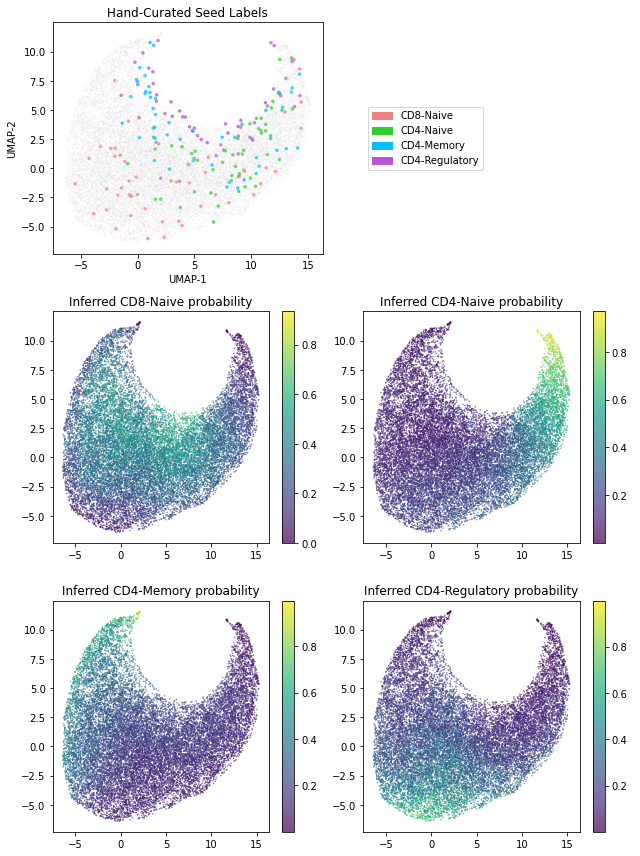

In [13]:
if not smoke_test:
    # Now that we're done training we'll inspect the latent representations we've learned
    import scanpy as sc
    
    # Put the neural networks in evaluation mode (needed because of batch norm)
    scanvi.eval()

    # Compute latent representation (z2_loc) for each cell in the dataset
    latent_rep = scanvi.z2l_encoder(dataloader.data_x)[0]

    # Compute inferred cell type probabilities for each cell
    y_logits = scanvi.classifier(latent_rep)
    # Convert logits to probabilities
    y_probs = softmax(y_logits, dim=-1).data.cpu().numpy()

    # Use scanpy to compute 2-dimensional UMAP coordinates using our
    # learned 10-dimensional latent representation z2
    anndata.obsm["X_scANVI"] = latent_rep.data.cpu().numpy()
    sc.pp.neighbors(anndata, use_rep="X_scANVI")
    sc.tl.umap(anndata)
    umap1, umap2 = anndata.obsm['X_umap'][:, 0], anndata.obsm['X_umap'][:, 1]

    # Construct plots; all plots are scatterplots depicting the two-dimensional UMAP embedding
    # and only differ in how points are colored

    # The topmost plot depicts the 200 hand-curated seed labels in our dataset
    fig, axes = plt.subplots(3, 2, figsize=(9, 12))
    seed_marker_sizes = anndata.obs['seed_marker_sizes']
    axes[0, 0].scatter(umap1, umap2, s=seed_marker_sizes, c=anndata.obs['seed_colors'], marker='.', alpha=0.7)
    axes[0, 0].set_title('Hand-Curated Seed Labels')
    axes[0, 0].set_xlabel('UMAP-1')
    axes[0, 0].set_ylabel('UMAP-2')
    patch1 = Patch(color='lightcoral', label='CD8-Naive')
    patch2 = Patch(color='limegreen', label='CD4-Naive')
    patch3 = Patch(color='deepskyblue', label='CD4-Memory')
    patch4 = Patch(color='mediumorchid', label='CD4-Regulatory')
    axes[0, 1].legend(loc='center left', handles=[patch1, patch2, patch3, patch4])
    axes[0, 1].get_xaxis().set_visible(False)
    axes[0, 1].get_yaxis().set_visible(False)
    axes[0, 1].set_frame_on(False)

    # The remaining plots depict the inferred cell type probability for each of the four cell types
    s10 = axes[1, 0].scatter(umap1, umap2, s=1, c=y_probs[:, 0], marker='.', alpha=0.7)
    axes[1, 0].set_title('Inferred CD8-Naive probability')
    fig.colorbar(s10, ax=axes[1, 0])
    s11 = axes[1, 1].scatter(umap1, umap2, s=1, c=y_probs[:, 1], marker='.', alpha=0.7)
    axes[1, 1].set_title('Inferred CD4-Naive probability')
    fig.colorbar(s11, ax=axes[1, 1])
    s20 = axes[2, 0].scatter(umap1, umap2, s=1, c=y_probs[:, 2], marker='.', alpha=0.7)
    axes[2, 0].set_title('Inferred CD4-Memory probability')
    fig.colorbar(s20, ax=axes[2, 0])
    s21 = axes[2, 1].scatter(umap1, umap2, s=1, c=y_probs[:, 3], marker='.', alpha=0.7)
    axes[2, 1].set_title('Inferred CD4-Regulatory probability')
    fig.colorbar(s21, ax=axes[2, 1])

    fig.tight_layout()